# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**

Due Date : 10/14 (October 14th), 11:59 PM EST

## Name: Brian Sohn

## UNI: bs3358

## The Dataset

### Acknowledgements

Big Thanks to https://www.superdatascience.com/pages/deep-learning

Banner Photo by Sharon McCutcheon on Unsplash

### Description

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [2]:
## YOUR CODE HERE
df_bank = pd.read_csv('HW2_dataset.csv')
df_bank

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608.0,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502.0,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699.0,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771.0,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516.0,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709.0,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772.0,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


**1.2: Plot % of missing values in each column. Would you consider dropping any columns? Assuming we want to train a decision tree, would you consider imputing the missing values? If not, why? (Remove the columns that you consider dropping)**

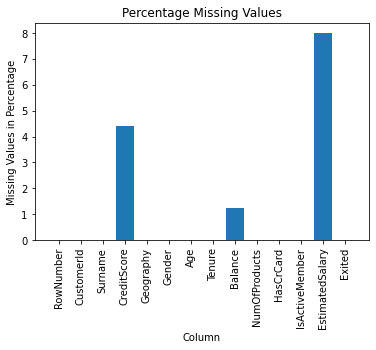

In [3]:
## YOUR CODE HERE
plt.bar(df_bank.columns, df_bank.isna().sum().values/len(df_bank)*100)
plt.xticks(rotation = 90)
plt.title('Percentage Missing Values')
plt.xlabel('Column')
plt.ylabel('Missing Values in Percentage')
plt.show()

# we will drop RowNumber, CustomerId, and Surname since they cannot be used to train our model. 
df_bank.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], inplace = True)



**What to do with missing values?**<br>

Although decision trees can handle missing values theoretically, sklearn's decision tree cannot handle it well. <br>

We don't want to throw the entire columns away since we lose too much information. <br>
We also don't want to impute columns with missing values using the mean value: this is because we don't know why there are missing values. For example, CreditScore might be missing since they do not have information in the credit bureau. This can be useful information in itself. Also, by simply using mean imputation, we might affect purity measures in the decision tree in an undesirable way. So instead of taking the risk of misleading the decision tree, for this assignment we will just build a model for observations where all the independent variables have values. Ideally, once we understand why there are missing values, we can remedy them accordingly and include them in our model.

As a sanity check, we check if it is safe to remove rows with missing values. We can verify that deleting rows with missing values will not distort the dataset hugely. 


In [4]:
print("overall proportion of exited:", df_bank.Exited.mean())
print("proportion of exited, CreditScore missing:", df_bank[df_bank.CreditScore.isna()].Exited.mean())
print("proportion of exited, Balance missing:", df_bank[df_bank.Balance.isna()].Exited.mean())
print("proportion of exited, EstimatedSalary missing:", df_bank[df_bank.EstimatedSalary.isna()].Exited.mean())




overall proportion of exited: 0.2037
proportion of exited, CreditScore missing: 0.18140589569160998
proportion of exited, Balance missing: 0.21138211382113822
proportion of exited, EstimatedSalary missing: 0.22125


In [5]:
# deleting rows with missing values
df_bank.dropna(inplace=True)
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      8636 non-null   float64
 1   Geography        8636 non-null   object 
 2   Gender           8636 non-null   object 
 3   Age              8636 non-null   int64  
 4   Tenure           8636 non-null   int64  
 5   Balance          8636 non-null   float64
 6   NumOfProducts    8636 non-null   int64  
 7   HasCrCard        8636 non-null   int64  
 8   IsActiveMember   8636 non-null   int64  
 9   EstimatedSalary  8636 non-null   float64
 10  Exited           8636 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 809.6+ KB


**1.3: Plot side-by-side bars of class distribtuion for each category for the categorical feature and the target categories.**

**Clarification with Example below : Here `flWinner` is the Target Variable and `descMapName` is a categorical feature. You are required to make such side-by-side bar plot for each categorical feature with repect to it's class distribution with the target feature for our dataset.**

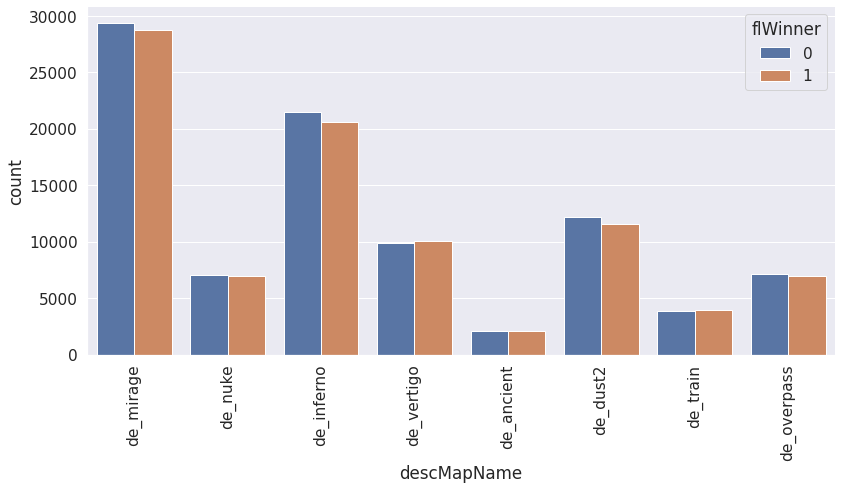

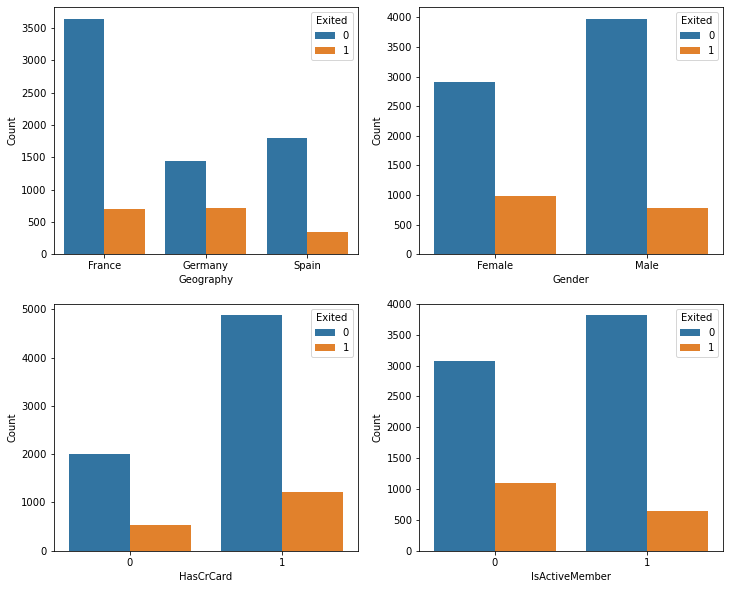

In [6]:
## YOUR CODE HERE
fig, axes = plt.subplots(2,2, figsize = (12,10))

dist_data1 = df_bank.groupby(['Geography', 'Exited']).Age.count().reset_index().rename(columns = {'Age':'Count'})
sns.barplot(data = dist_data1, x = 'Geography', y = 'Count', hue = 'Exited', ax = axes[0,0])

dist_data2 = df_bank.groupby(['Gender', 'Exited']).Age.count().reset_index().rename(columns = {'Age':'Count'})
sns.barplot(data = dist_data2, x = 'Gender', y = 'Count', hue = 'Exited', ax = axes[0,1])

dist_data3 = df_bank.groupby(['HasCrCard', 'Exited']).Age.count().reset_index().rename(columns = {'Age':'Count'})
sns.barplot(data = dist_data3, x = 'HasCrCard', y = 'Count', hue = 'Exited', ax = axes[1,0])

dist_data4 = df_bank.groupby(['IsActiveMember', 'Exited']).Age.count().reset_index().rename(columns = {'Age':'Count'})
sns.barplot(data = dist_data4, x = 'IsActiveMember', y = 'Count', hue = 'Exited', ax = axes[1,1])

plt.show()

**1.4: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

In [7]:
## YOUR CODE HERE
from sklearn.model_selection import train_test_split

X = df_bank.drop(columns = ['Exited'])
y = df_bank.Exited
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# I am doing a random split
# there is no need for a structured split as this is not a time series data. 
# We also don't really need a stratified split because our data size for the minority case is still pretty big.  

**1.5: Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify**

In [8]:
## YOUR CODE HERE
from sklearn.preprocessing import OneHotEncoder

# handling Geography - one-hot encoding
ohe = OneHotEncoder()
geo_transformed = ohe.fit_transform(np.array(X_dev.Geography).reshape(-1,1))
X_dev['France'], X_dev['Germany'] = geo_transformed.toarray()[:,0:2].T
X_test['France'], X_test['Germany'] = ohe.transform(np.array(X_test.Geography).reshape(-1,1)).toarray()[:,0:2].T

# handling gender - creating a one-hot encoded column manually
X_dev['GenderDummy'] = np.where(X_dev['Gender']=="Male", 0, 1)
X_test['GenderDummy'] = np.where(X_test['Gender']=="Male", 0, 1)

# HasCrCard, IsActiveMember are already one-hot encoded, so no need for processing

# dropping columns no longer needed
X_dev.drop(columns = ['Geography', 'Gender'], inplace = True)
X_test.drop(columns = ['Geography', 'Gender'], inplace = True)

# We won't need to scale the data: theoretically Decision Trees do not require scaling since the variance of the data does not impace purity measures 

**1.6: Fit a Decision Tree on the development data until all leaves are pure. What is the performance of the tree on the development set and test set? Provide metrics you believe are relevant and briefly justify.**

In [9]:
## YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dt = DecisionTreeClassifier(random_state=0) # defaults to training until all leaves are pure
dt.fit(X_dev, y_dev)

y_dev_pred = dt.predict(X_dev)
y_test_pred = dt.predict(X_test)

print("development f1 score:", f1_score(y_dev, y_dev_pred))
print("test f1 score:", f1_score(y_test, y_test_pred))

# The dataset is quite imbalanced, so we are not using accuracy
# we don't know the costs associated with misclassifying, so choosing f1_score instead of precision or recall is a more balanced choice. 
# exited customers are our interest, so we calculate f1_score for Exited = 1(default)

# development f1 is 1 since we trained it to learn everything perfectly
# but this would obviously have overfitted, so test f1 is much lower

development f1 score: 1.0
test f1 score: 0.525065963060686


**1.7: Visualize the trained tree until the max_depth 8**

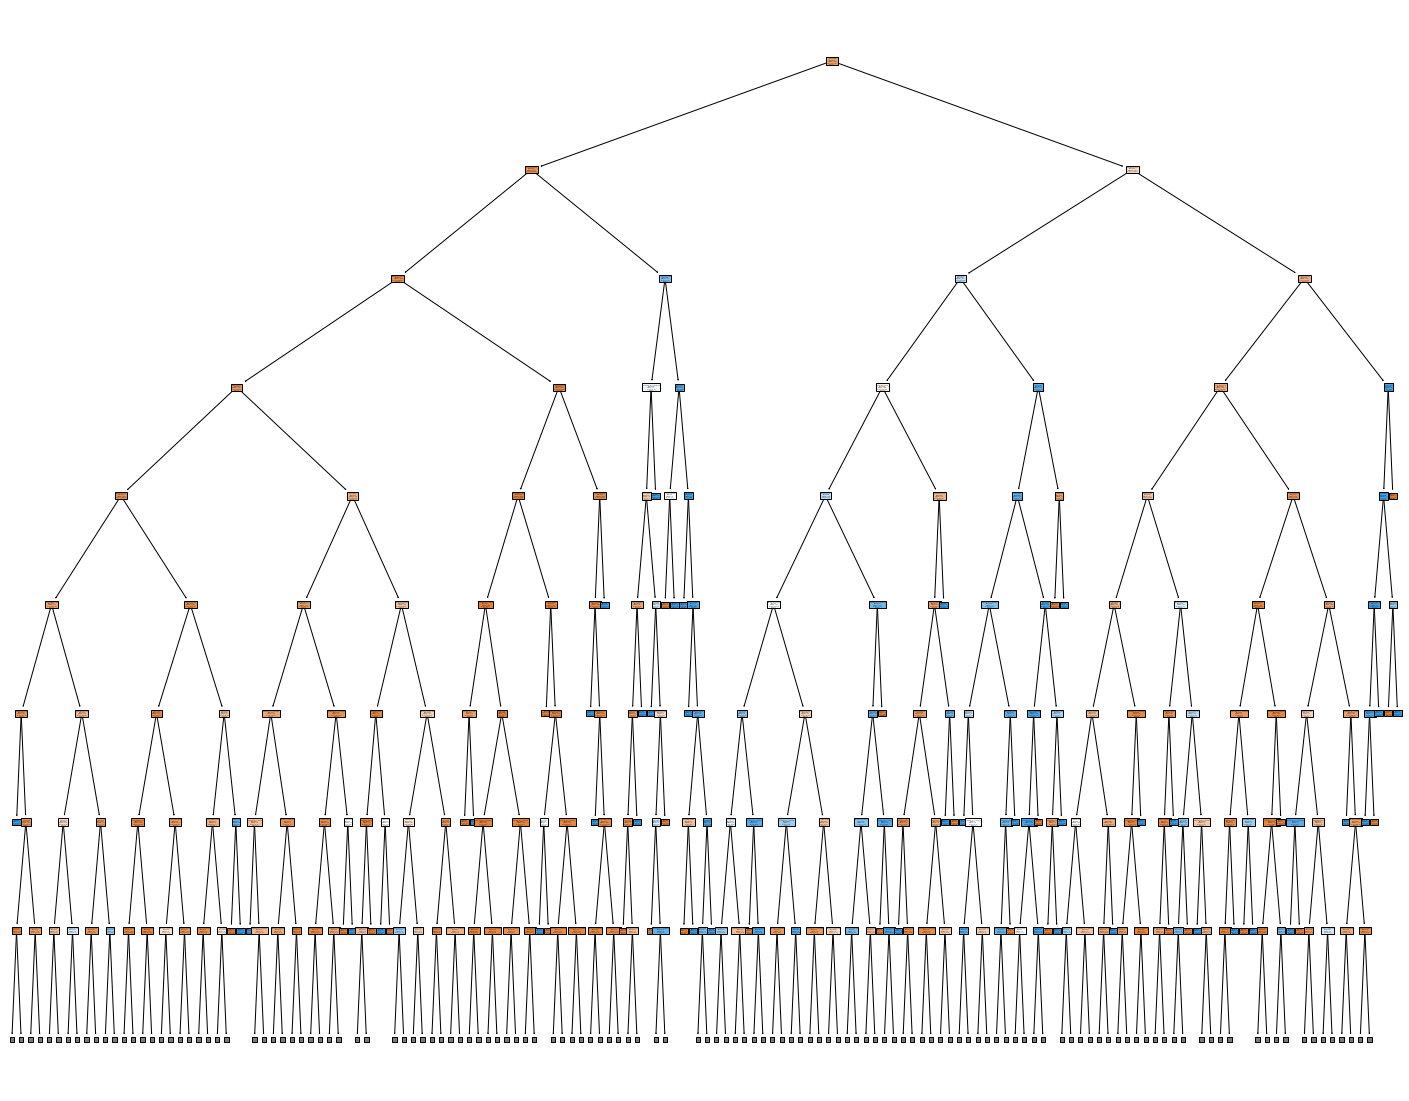

In [10]:
## YOUR CODE HERE
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt, 
              max_depth=8, 
              filled=True,
              feature_names=X_dev.columns,  
              class_names=['0','1'])

**1.8: Prune the tree using one of the techniques discussed in class and evaluate the performance**

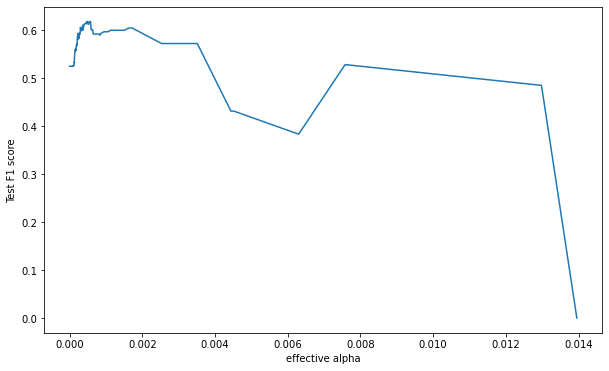

In [11]:
## YOUR CODE HERE
# cost complexity pruning
path = dt.cost_complexity_pruning_path(X_dev, y_dev)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

dts = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_dev, y_dev)
    dts.append(clf)

scores = [f1_score(y_test, clf.predict(X_test)) for clf in dts]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Test F1 score")
plt.show()

best_alpha = ccp_alphas[scores.index(max(scores))]

In [12]:
dt_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)

dt_pruned.fit(X_dev, y_dev)

pruned_y_dev_pred = dt_pruned.predict(X_dev)
pruned_y_test_pred = dt_pruned.predict(X_test)

print("development f1 score, pruned:", f1_score(y_dev, pruned_y_dev_pred))
print("test f1 score, pruned:", f1_score(y_test, pruned_y_test_pred))

# We can check that our test f1 score has increased due to less overfitting

development f1 score, pruned: 0.6425738210665491
test f1 score, pruned: 0.618421052631579


**1.9: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

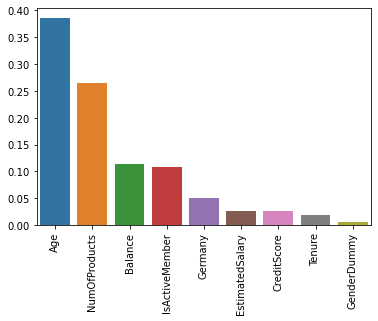

In [13]:
## YOUR CODE HERE
feature_names = X_dev.columns
feat_imps = zip(feature_names, dt_pruned.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key = lambda x: x[1], reverse = True)))
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis = 'x', rotation = 90)

# Age, NumOfProducts, Balance

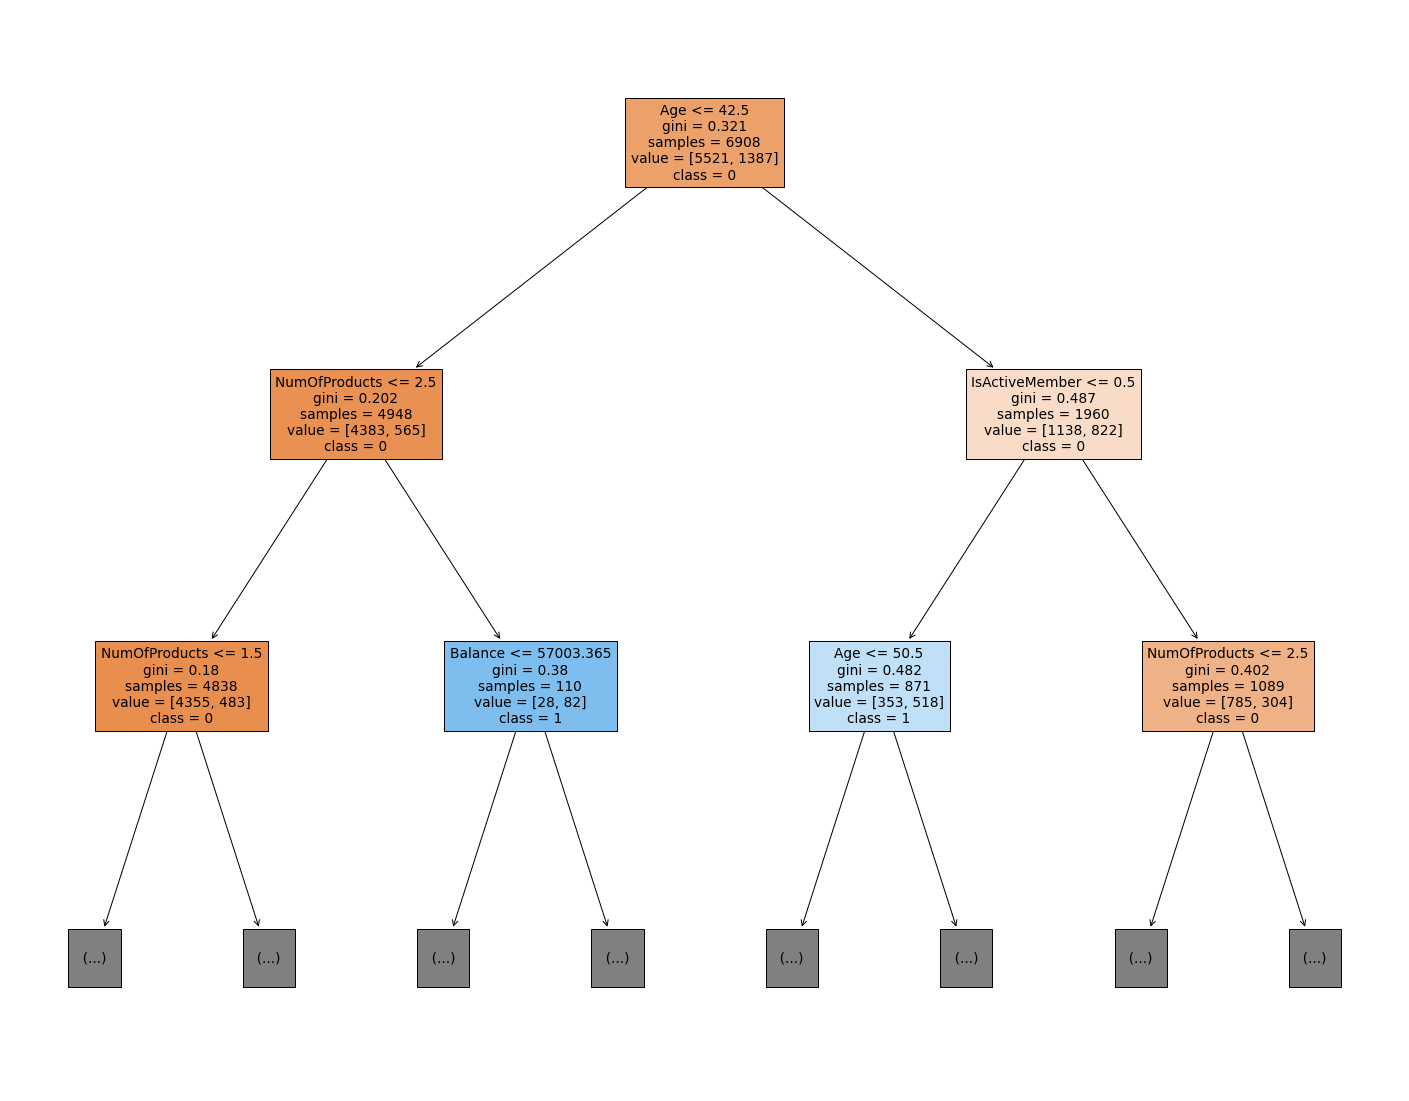

In [14]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_pruned, 
              max_depth=2, 
              filled=True,
              feature_names=X_dev.columns,  
              class_names=['0','1'])

The three most important factors in this (pruned) decision tree are Age, NumOfProducts, and Balance. <br>
It seems older people, people with less products, and people with higher balance have a higher chance of closing an account. 

In [15]:
print(df_bank.groupby('Exited').Age.median())
print(df_bank.groupby('Exited').NumOfProducts.median())
print(df_bank.groupby('Exited').Balance.median())


Exited
0    36
1    45
Name: Age, dtype: int64
Exited
0    2
1    1
Name: NumOfProducts, dtype: int64
Exited
0     91617.300
1    109838.185
Name: Balance, dtype: float64


## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.6)?**

In [16]:
## YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_dev, y_dev)

y_dev_pred_rf = rf.predict(X_dev)
y_test_pred_rf = rf.predict(X_test)

print("development f1 score:", f1_score(y_dev, y_dev_pred_rf))
print("test f1 score:", f1_score(y_test, y_test_pred_rf))

# the test f1 score, 0.60, is better than the decision tree's test f1 score, 0.52. 

development f1 score: 1.0
test f1 score: 0.6026490066225165


**2.2: Does all trees in the trained random forest model have pure leaves? How would you verify this?**

In [17]:
## YOUR CODE HERE

# Yes. 
# First, we get a development f1-score of 1.0, which can only be achieved if the development data is trained perfectly - or every leaf is pure. 
# Second, the documentation says that the default parameters train a random forest until all leaves are pure. 


**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


In [18]:
## YOUR ANSWER HERE

# I would choose number of trees and maximum depth. Number of trees determine how to ensemble trees, and maximum depth prevents overfitting in each tree. 

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

In [19]:
## YOUR ANSWER HERE

# I will use a grid search
# number of trees: 50, 100, 200, 300, 500 - check if increasing number of trees will be better than default (100)
# max depth: 3,6, 9, 12, 15 - these are some numbers that are typically used, but are subject to change. 

**2.5: Perform model selection using the chosen values for the hyperparameters. Use cross-validation for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [20]:
## YOUR CODE HERE
from sklearn.model_selection import cross_val_score

n_estimators = [50,100,200,300,500]
depths = [3,6,9,12,15]

kfold_val_scores = []

# 5-fold cross validation
for estimator in n_estimators:
    for depth in depths: 
        rf_model = RandomForestClassifier(n_estimators = estimator, max_depth = depth, random_state=0)
        scores = cross_val_score(rf_model, X_dev, y_dev, scoring='f1', cv=5)
        kfold_val_scores.append((estimator, depth, np.mean(scores)))

# best parameters

best_params = sorted(kfold_val_scores, key=lambda y: y[2], reverse=True)[0]

print("Best n_estimators: ", best_params[0])
print("Best max_depth: ", best_params[1])

# performance of best model
rf_best = RandomForestClassifier(n_estimators = best_params[0], max_depth = best_params[1], random_state=0)
rf_best.fit(X_dev, y_dev)
y_pred_rf_tuned = rf_best.predict(X_test)
print("test f1 score:", f1_score(y_test, y_pred_rf_tuned))



Best n_estimators:  500
Best max_depth:  15
test f1 score: 0.6037099494097807


The test f1 score in the tuned model, 0.6037, is slightly better than the f1 score of the plain-vanilla model, 0.6026. 

**2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.9? If they differ, which feature set makes more sense?**

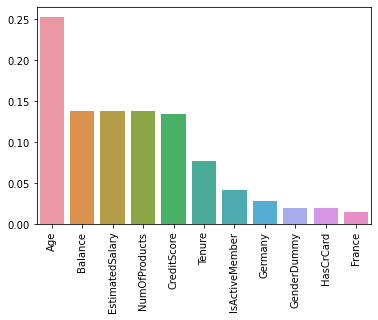

In [21]:
## YOUR CODE HERE
feature_names = X_dev.columns
feat_imps = zip(feature_names, rf_best.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key = lambda x: x[1], reverse = True)))
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis = 'x', rotation = 90)

# Age, Balance, Estimated Salary are the 3 most impotant in this model (although NumOfProducts is a close 4th)
# To me, the random forest model makes more sense since estimated salary might also play some role. 

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune GradientBoostingClassifier and HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. Report on the time taken to do model selection for both the models. Also, report the performance of the test dataset from the optimal models.**

In [22]:
## YOUR CODE HERE
import time
from sklearn.ensemble import GradientBoostingClassifier

# We choose number of trees, learning_rate, and max_depth as hyperparameters to tune and search 3 levels of each hyperparameter.

n_trees = [50,100,300]
lrates = [0.1, 0.05, 0.01]
depths = [3,7,11]

kfold_val_scores_gbc = []

# record starting time 
start_time = time.time()

# 5-fold cross validation
for ntree in n_trees:
    for lrate in lrates:
        for depth in depths:
            gbc_model = GradientBoostingClassifier(n_estimators = ntree, learning_rate = lrate, max_depth = depth, random_state=0)
            scores = cross_val_score(gbc_model, X_dev, y_dev, scoring='f1', cv=5)
            kfold_val_scores_gbc.append((ntree, lrate, depth, np.mean(scores)))


# best parameters

best_params = sorted(kfold_val_scores_gbc, key=lambda y: y[3], reverse=True)[0]

print("--- %s seconds ---" % (time.time() - start_time))

print("Best n_estimators: ", best_params[0])
print("Best learning rate: ", best_params[1])
print("Best max_depth: ", best_params[2])

# performance of best model
gbc_best = GradientBoostingClassifier(n_estimators = best_params[0], learning_rate = best_params[1], max_depth = best_params[2], random_state=0)
gbc_best.fit(X_dev, y_dev)
y_pred_gbc = gbc_best.predict(X_test)
print("GBC test f1 score:", f1_score(y_test, y_pred_gbc))




--- 686.5420019626617 seconds ---
Best n_estimators:  100
Best learning rate:  0.1
Best max_depth:  3
GBC test f1 score: 0.5902192242833052


In [23]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# We choose max number of trees, learning_rate, and max_depth as hyperparameters to tune and search 3 levels of each hyperparameter.

kfold_val_scores_hgbc = []

# record starting time 
start_time = time.time()

# 5-fold cross validation
for ntree in n_trees:
    for lrate in lrates:
        for depth in depths:
            hgbc_model = HistGradientBoostingClassifier(max_iter = ntree, learning_rate = lrate, max_depth = depth, random_state=0)
            scores = cross_val_score(hgbc_model, X_dev, y_dev, scoring='f1', cv=5)
            kfold_val_scores_hgbc.append((ntree, lrate, depth, np.mean(scores)))


# best parameters

best_params = sorted(kfold_val_scores_hgbc, key=lambda y: y[3], reverse=True)[0]

print("--- %s seconds ---" % (time.time() - start_time))

print("Best max_iter: ", best_params[0])
print("Best learning rate: ", best_params[1])
print("Best max_depth: ", best_params[2])

# performance of best model
hgbc_best = HistGradientBoostingClassifier(max_iter = best_params[0], learning_rate = best_params[1], max_depth = best_params[2], random_state=0)
hgbc_best.fit(X_dev, y_dev)
y_pred_hgbc = hgbc_best.predict(X_test)
print("HGBC test f1 score:", f1_score(y_test, y_pred_hgbc))



--- 318.03999757766724 seconds ---
Best max_iter:  300
Best learning rate:  0.05
Best max_depth:  7
HGBC test f1 score: 0.6148867313915857


**3.2: Train an XGBoost model by tuning 3 hyperparameters using 10 fold cross-validation. Compare the performance of the trained XGBoost model on the test dataset against the performances obtained from 3.1**

In [24]:
## YOUR CODE HERE
import xgboost as xgb

n_trees = [50,100,300]
lrates = [0.1, 0.05, 0.01]
depths = [3,7,11]


kfold_val_scores_xgb = []

# record starting time 
start_time = time.time()

# 5-fold cross validation
for ntree in n_trees:
    for lrate in lrates:
        for depth in depths:
            xgb_model = xgb.XGBClassifier(n_estimators = ntree, learning_rate = lrate, max_depth=depth, random_state=0)
            scores = cross_val_score(xgb_model, X_dev, y_dev, scoring='f1', cv=10)
            kfold_val_scores_xgb.append((ntree, lrate, depth, np.mean(scores)))


# best parameters

best_params = sorted(kfold_val_scores_xgb, key=lambda y: y[3], reverse=True)[0]

print("--- %s seconds ---" % (time.time() - start_time))

print("Best n_estimators: ", best_params[0])
print("Best learning rate: ", best_params[1])
print("Best max_depth: ", best_params[2])

# performance of best model
xgb_best =  xgb.XGBClassifier(n_estimators = best_params[0], learning_rate = best_params[1], max_depth = best_params[2], random_state=0)
xgb_best.fit(X_dev, y_dev)
y_pred_xgb = xgb_best.predict(X_test)
print("XGBoost test f1 score:", f1_score(y_test, y_pred_xgb))


--- 453.02400183677673 seconds ---
Best n_estimators:  300
Best learning rate:  0.1
Best max_depth:  3
XGBoost test f1 score: 0.5986622073578595


The test f1 score is higher than GradientBoostingClassifier but lower than HistGradientBoostingClassifier. 

**3.3: Compare the results on the test dataset from XGBoost, HistGradientBoostingClassifier, GradientBoostingClassifier with results from Q1.6 and Q2.1. Which model tends to perform the best and which one does the worst? How big is the difference between the two? Which model would you choose among these 5 models and why?**

In [25]:
## YOUR ANSWER HERE
print("DT(default) test f1 score:", f1_score(y_test, y_test_pred))
print("RF(default) test f1 score:", f1_score(y_test, y_test_pred_rf))
print("GBC test f1 score:", f1_score(y_test, y_pred_gbc))
print("HGBC test f1 score:", f1_score(y_test, y_pred_hgbc))
print("XGBoost test f1 score:", f1_score(y_test, y_pred_xgb))


DT(default) test f1 score: 0.525065963060686
RF(default) test f1 score: 0.6026490066225165
GBC test f1 score: 0.5902192242833052
HGBC test f1 score: 0.6148867313915857
XGBoost test f1 score: 0.5986622073578595


HistGradientBoosting performed the best, and Decision Tree (default) performed the worst. The difference in their f1 scores is almost 0.09. 

I would choose HistGradientBoosting since it has the highest performance and is relatively quick. 

**3.4: Can you list the top 3 features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree? Which one would you trust the most?**

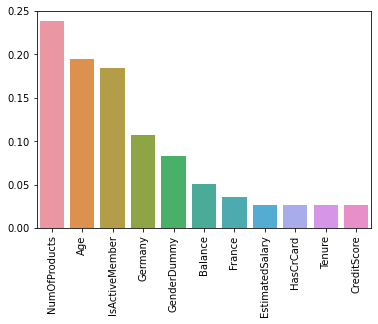

In [26]:
## YOUR CODE HERE
feature_names = X_dev.columns
feat_imps = zip(feature_names, xgb_best.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key = lambda x: x[1], reverse = True)))
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis = 'x', rotation = 90)

# top 3 features from xgboost are NumOfProducts, Age, and IsActiveMember. 
# This model put IsActiveMember as one of the top 3 important factors, unlike the other models.
# Given that the 3 models have similar performances, I trust the xgboost model's interpretations, 
# because a customer's interaction with the bank (NumofProducts, IsActiveMember) should be important. 

**3.5: Can you choose the top 7 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [27]:
## YOUR CODE HERE
X_dev_top7 = X_dev[['NumOfProducts', 'Age', 'IsActiveMember', 'Germany', 'GenderDummy', 'Balance', 'France']]
X_test_top7 = X_test[['NumOfProducts', 'Age', 'IsActiveMember', 'Germany', 'GenderDummy', 'Balance', 'France']]


n_trees = [50,100,300]
lrates = [0.1, 0.05, 0.01]
depths = [3,7,11]

kfold_val_scores_xgb7 = []

# record starting time 
start_time = time.time()

# 5-fold cross validation
for ntree in n_trees:
    for lrate in lrates:
        for depth in depths:
            xgb_model = xgb.XGBClassifier(n_estimators = ntree, learning_rate = lrate, max_depth=depth, random_state=0)
            scores = cross_val_score(xgb_model, X_dev_top7, y_dev, scoring='f1', cv=10)
            kfold_val_scores_xgb7.append((ntree, lrate, depth, np.mean(scores)))


# best parameters

best_params = sorted(kfold_val_scores_xgb7, key=lambda y: y[3], reverse=True)[0]

print("--- %s seconds ---" % (time.time() - start_time))

print("Best n_estimators: ", best_params[0])
print("Best learning rate: ", best_params[1])
print("Best max_depth: ", best_params[2])

# performance of best model
xgb_best7 =  xgb.XGBClassifier(n_estimators = best_params[0], learning_rate = best_params[1], max_depth = best_params[2], random_state=0)
xgb_best7.fit(X_dev_top7, y_dev)
y_pred_xgb7 = xgb_best7.predict(X_test_top7)
print("XGBoost test f1 score:", f1_score(y_test, y_pred_xgb7))


--- 338.9510006904602 seconds ---
Best n_estimators:  300
Best learning rate:  0.1
Best max_depth:  3
XGBoost test f1 score: 0.6069651741293532


The model with top 7 features performed slightly better (higher f1 score). This could be because by removing unnecessary features, we are removing noise in the data and preventing overfitting. 

## Question 4: Calibration

**4.1: Estimate the brier score for the XGBoost model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [28]:
## YOUR CODE HERE
from sklearn.metrics import brier_score_loss

y_prob = xgb_best.predict_proba(X_test)[:,1]
print("brier score on the test set for XGBoost: ", brier_score_loss(y_test, y_prob)) 


brier score on the test set for XGBoost:  0.1022302370516658


**4.2: Calibrate the trained XGBoost model using isotonic regression as well as Platt scaling. Plot predicted v.s. actual on test datasets from both the calibration methods**

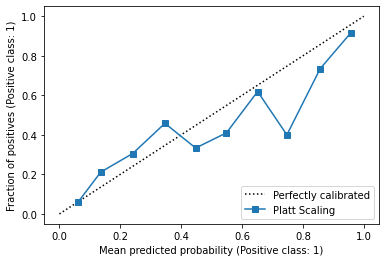

In [29]:
## YOUR CODE HERE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay

X_train, X_calib, y_train, y_calib = train_test_split(X_dev, y_dev, test_size = 0.2, random_state=37)

xgb_platt = CalibratedClassifierCV(xgb_best, cv='prefit', method='sigmoid')
xgb_platt.fit(X_calib, y_calib)
display = CalibrationDisplay.from_estimator(xgb_platt, X_test, y_test, n_bins=10, name='Platt Scaling')

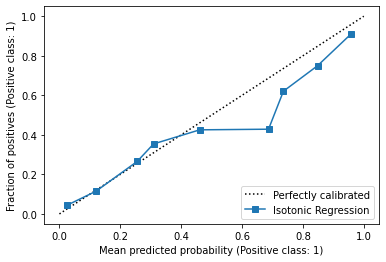

In [30]:
xgb_iso = CalibratedClassifierCV(xgb_best, cv='prefit', method='isotonic')
xgb_iso.fit(X_calib, y_calib)
display = CalibrationDisplay.from_estimator(xgb_iso, X_test, y_test, n_bins=10, name='Isotonic Regression')

**4.3: Report brier scores from both the calibration methods. Do the calibration methods help in having better predicted probabilities?**

In [31]:
## YOUR CODE HERE

y_prob_platt = xgb_platt.predict_proba(X_test)[:,1]
y_prob_iso = xgb_iso.predict_proba(X_test)[:,1]

print("brier score, Platt Scaling: ", brier_score_loss(y_test, y_prob_platt)) 
print("brier score, Isotonic Regression: ", brier_score_loss(y_test, y_prob_iso)) 

# higher than original xgboost without calibration

brier score, Platt Scaling:  0.10570243239395419
brier score, Isotonic Regression:  0.10324252786559741


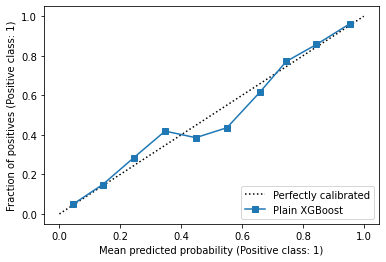

In [33]:
display = CalibrationDisplay.from_estimator(xgb_best, X_test, y_test, n_bins=10, name='Plain XGBoost')

The calibration methods did not help in having better predicted probabilities, as shown in both the calibration curve and brier scores (increased).  